In [18]:
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image, ImageDraw
from IPython.display import Image as IPyImage
import numpy as np
import time
import cv2

# For drawing onto the image.
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# 设置模型

In [15]:
ALL_MODELS = {
    'CenterNet HourGlass104 512x512':
    'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
    'EfficientDet D0 512x512':
    'https://tfhub.dev/tensorflow/efficientdet/d0/1',
    'EfficientDet D1 640x640':
    'https://tfhub.dev/tensorflow/efficientdet/d1/1',
    'SSD MobileNet v2 320x320':
    'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
    'SSD MobileNet V1 FPN 640x640':
    'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
    'SSD MobileNet V2 FPNLite 320x320':
    'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
    'SSD MobileNet V2 FPNLite 640x640':
    'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
    'Faster R-CNN ResNet50 V1 640x640':
    'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
}

## total clases
classes = {1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'microwave', 79: 'oven', 80: 'toaster', 81: 'sink', 82: 'refrigerator', 84: 'book', 85: 'clock', 86: 'vase', 87: 'scissors', 88: 'teddy bear', 89: 'hair drier', 90: 'toothbrush'}

In [5]:
model_name = 'SSD MobileNet V2 FPNLite 320x320'
model_handle = ALL_MODELS[model_name]
print('Selected model:'+ model_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))
detector = hub.load(model_handle)
print('Model loaded')

Selected model:SSD MobileNet V2 FPNLite 320x320
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1
Model loaded


# Utils

In [22]:
def read_image(image_path, target_size=None):
    image = tf.keras.preprocessing.image.load_img(image_path,
                target_size=target_size)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image.astype(np.uint8)
    return image


def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax,
                               color, font, thickness=4, display_str_list=()): 
    """
    添加Bounding Box到图片上
    ymin, xmin, ymax, xmax是bounding box的归一化坐标
    """

    draw = ImageDraw.Draw(image) # 画图
    im_width, im_height = image.size # 图片的宽高
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                  ymin * im_height, ymax * im_height) # 计算bounding box的坐标
    
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
               (left, top)], width=thickness, fill=color) # 画bounding box

    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list] # 遍历标签文本，计算每个字的高度

    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights) # 计算标签文本的总高度

    if top > total_display_str_height: # 使得文本不会超出图像的上边界，同时尽可能保持文本在边界框上方
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height

    for display_str in display_str_list[::-1]: # 计算文本到边界框边界的距离，绘制文本
        text_width, text_height = font.getsize(display_str) 
        margin = np.ceil(0.05 * text_height) 
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.45):
    """
    绘制多个bounding box到图片上
    为每个box添加类别标签和置信度
    控制置信度阈值和box个数

    box是一个Numpy数组，每一行是一个bounding box，格式为：[ymin, xmin, ymax, xmax]
    """
    colors = list(ImageColor.colormap.values()) # 颜色列表

    font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)): # 遍历每个box，不超过最大box个数
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            if not(i < len(class_names) and i < len(scores)):
                continue
            display_str = "{}: {}%".format(class_names[i],
                                           int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(image_pil, ymin, xmin,ymax, xmax, color, font, display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image


def run_detector(detector, image, classes):

    converted_img = np.expand_dims(image, 0)

    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key: value.numpy() for key, value in result.items()}
    print("Inference time: ", end_time - start_time)

    classes_names = [classes[i] for i in result["detection_classes"][0] if i in classes]

    detection_boxes = result["detection_boxes"][0]
    detection_scores = result["detection_scores"][0]
    image_with_boxes = draw_boxes(image, detection_boxes,
                                  classes_names, detection_scores)

    return image_with_boxes

# 简单的图片检测

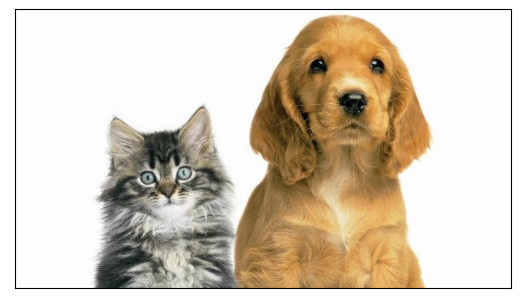

In [23]:
url = 'https://akm-img-a-in.tosshub.com/indiatoday/images/story/201812/dogs_and_cats.jpeg?TAxD19DTCFE7WiSYLUdTu446cfW4AbuW&size=770:433'
image_path = tf.keras.utils.get_file("dog-cat2.jpg", url)
image = read_image(image_path)
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

In [24]:
converted_img = np.expand_dims(image, 0)
t = time.time()
result = detector(converted_img)
print("Inference time: ", time.time() - t)
# result.keys()
# result['detection_scores']

Inference time:  0.08953356742858887


Inference time:  0.14238214492797852


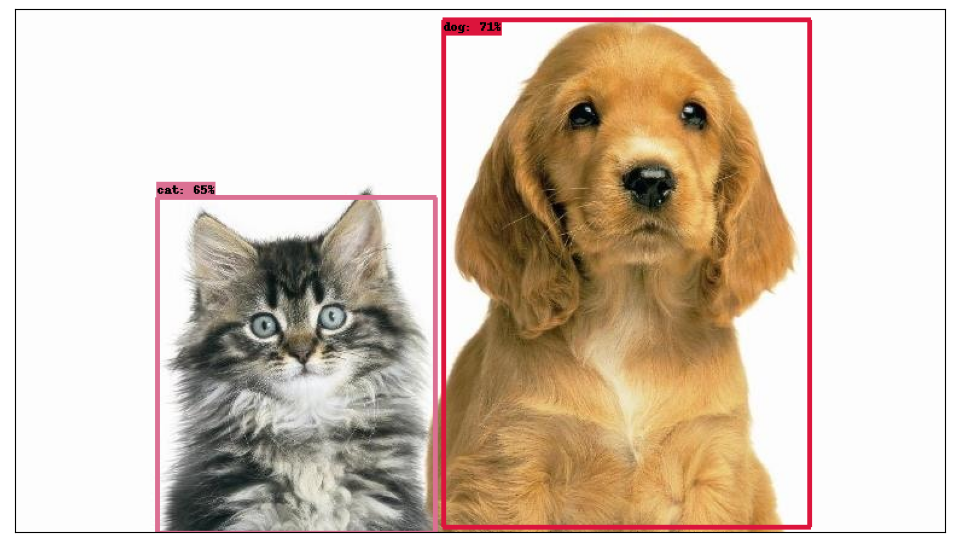

In [25]:
image_with_boxes = run_detector(detector, image, classes)
plt.figure(figsize=(12, 12))
plt.imshow(image_with_boxes)
plt.xticks([])
plt.yticks([])
plt.show()

# 使用YOLO模型进行实时检测

In [33]:
def load_yolo_model():
    # 导入YOLO模型和权重
    net = cv2.dnn.readNet("yolov4.weights", "yolov4.cfg")

    # 导入coco数据集的类别
    with open("coco.names", "r") as f:
        classes = [line.strip() for line in f.readlines()]

    return net, classes


def detect_objects(img, net):
    blob = cv2.dnn.blobFromImage(img, 1/255, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    # layer_names = net.getLayerNames()
    # output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
    output_layers = ['yolo_161']
    outputs = net.forward(output_layers)
    return outputs

# 导入YOLO模型
net, classes = load_yolo_model()
print(f'classes: {classes}')

classes: ['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [30]:
def draw_boxes(img, detections, classes):
    height, width, channels = img.shape
    class_ids = []
    confidences = []
    boxes = []

    for output in detections:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    for i in indices:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        color = np.random.randint(0, 255, 3).tolist()
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
        cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return img

## 开始检测

In [34]:
cap = cv2.VideoCapture(0)
time.sleep(1)

axes = None
NUM_FRAMES = 30  
processed_imgs = []
for i in range(NUM_FRAMES):
    # Load frame from the camera
    ret, frame = cap.read()
    detections = detect_objects(frame, net)
    image_boxes = draw_boxes(frame, detections, classes)

    img = Image.fromarray(np.uint8(image_boxes))#.convert('RGB')
    processed_imgs.append(img)
    cv2.imshow("test", cv2.cvtColor(image_boxes, cv2.COLOR_BGR2RGB))
    cv2.waitKey(1)

KeyboardInterrupt: 

In [35]:
cap.release()
cv2.destroyAllWindows()

In [ ]:
## create gif
processed_imgs[0].save('web_cam.gif', format='GIF', append_images=processed_imgs[1:], save_all=True, duration=100, loop=0)
IPyImage('web_cam.gif', format='png', width=15 * 40, height=3 * 40) 

# 人体姿态估计